Among the $1000$ simulated galaxy spectra, for roughly $\sim80$ galaxies, `Redrock` measures a redshift that deviates significantly from the true (input) redshift $\Delta z > 0.1$. In this notebook we investigate these galaxies and what may be causing this to happen.

In [32]:
import os
import numpy as np 
from scipy.signal import medfilt
# -- astropy --
import redrock as RedRock
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io import write_spectra
from desispec.spectra import Spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [ ]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

First lets identify and write out all the simulated spectra for the cases where `redrock` recovers the correct redshift for the bright sky case, but _not_ the dark sky case.

In [15]:
field = 'g15'
# read in GAMA-Legacy survey
cata = Cat.GamaLegacy()
gleg = cata.Read(field)
if field == 'g09': 
    nblocks = 26
elif field == 'g15': 
    nblocks = 64

In [8]:
redshift = gleg['gama-spec']['z']
ngal = len(redshift)
print('%i galaxies in the GAMA-Legacy survey' % ngal)

63004 galaxies in the GAMA-Legacy survey


In [10]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

In [16]:
i_block = 5
dir_redrock = ''.join([UT.dat_dir(), 'redrock/'])
dir_spectra = ''.join([UT.dat_dir(), 'spectra/'])

f_z_dark = ''.join([dir_redrock, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([dir_spectra, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')

f_z_bright = ''.join([dir_redrock, 
                      'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zbright_data = fits.open(f_z_bright)[1].data

f_i_bright = ''.join([dir_spectra, 
                      'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_bright = np.loadtxt(f_i_bright, unpack=True, usecols=[0], dtype='i')

In [17]:
assert np.array_equal(i_dark, i_bright)
print('%i simulated spectra with redrock redshifts' % len(zdark_data['Z']))

1000 simulated spectra with redrock redshifts


In [18]:
mag_cut = (r_mag_legacy_apflux[i_dark] < 25.0)

(0.7, 1.0)

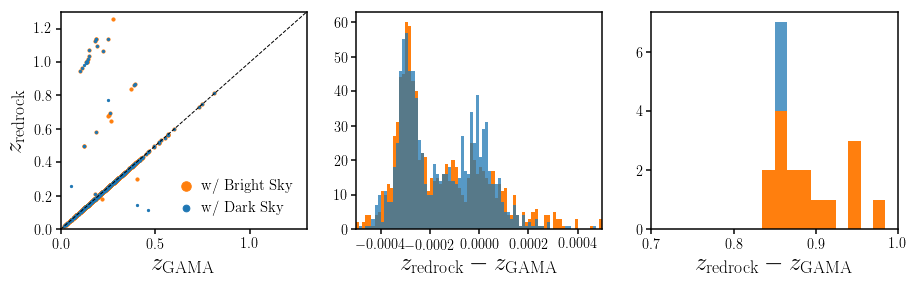

In [19]:
fig = plt.figure(figsize=(15,4))
sub = fig.add_subplot(131)
sub.scatter(redshift[i_dark][mag_cut], zbright_data['Z'][mag_cut], c='C1', s=10, label='w/ Bright Sky')
sub.scatter(redshift[i_dark][mag_cut], zdark_data['Z'][mag_cut], c='C0', s=5, label='w/ Dark Sky')
sub.plot([0., 10.], [0., 10.], c='k', lw=1, ls='--')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0., 1.3])
sub.set_ylabel(r"$z_\mathrm{redrock}$", fontsize=25)
sub.set_ylim([0., 1.3])
sub.legend(loc='lower right', markerscale=3, handletextpad=0., prop={'size':15})
sub = fig.add_subplot(132)
_ = sub.hist(zbright_data['Z'][mag_cut] - redshift[i_dark][mag_cut], color='C1', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'][mag_cut] - redshift[i_dark][mag_cut], color='C0', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([-0.0005, 0.0005])
sub = fig.add_subplot(133)
_ = sub.hist(zdark_data['Z'][mag_cut] - redshift[i_dark][mag_cut], color='C0', 
             range=(0.7, 1), bins=20, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
_ = sub.hist(zbright_data['Z'][mag_cut] - redshift[i_dark][mag_cut], color='C1', 
             range=(0.7,1.), bins=20, histtype='stepfilled', label='w/ Bright Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0.7, 1.0])

In [20]:
weird = ((zdark_data['Z'][mag_cut] - redshift[i_dark][mag_cut] >  0.1) & 
         (zbright_data['Z'][mag_cut] - redshift[i_dark][mag_cut] < 0.1))
print('%i simulated spectra have more accurate redrock redshifts when using bright sky' % np.sum(weird))

4 simulated spectra have more accurate redrock redshifts when using bright sky


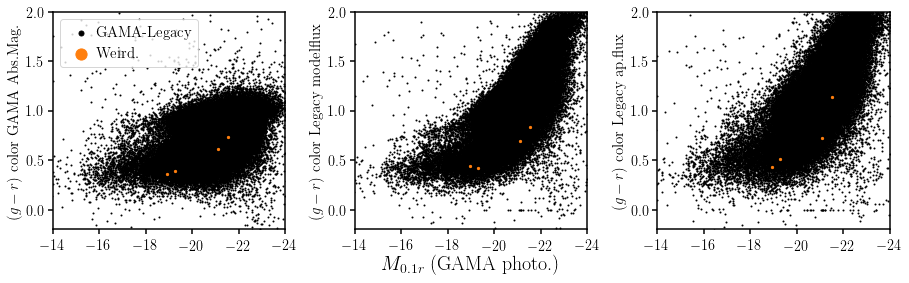

In [21]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1., label='GAMA-Legacy')
    sub.scatter(r_absmag_gama[i_dark][mag_cut][weird], y[i_dark][mag_cut][weird], c='C1', s=5, label='Weird.')
    if i == 2: sub.set_xlabel('$M_{0.1r}$ (GAMA photo.)', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 2.])
    if i == 1: sub.legend(loc="upper left", markerscale=5, handletextpad=0., frameon=True, prop={'size':15})
fig.subplots_adjust(wspace=0.3)

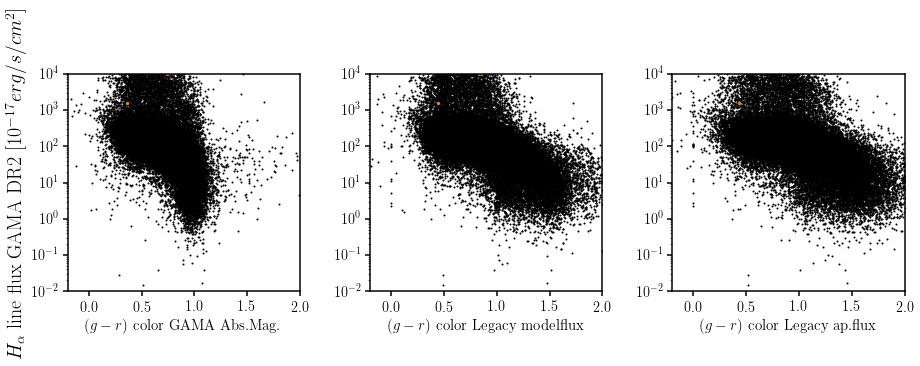

In [22]:
fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    sub.scatter(x, gama_ha, s=1, c='k', label='GAMA-Legacy')
    sub.scatter(x[i_dark][mag_cut][weird], gama_ha[i_dark][mag_cut][weird], c='C1', s=5, 
                label='Weird.')  
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([1e-2, 1e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)


Now lets write out these 24 simulated spectra with dark and bright skies

In [24]:
f_spec_dark = ''.join([dir_spectra, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])
spec_dark = read_spectra(f_spec_dark)
f_spec_bright = ''.join([dir_spectra, 
                      'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])
spec_bright = read_spectra(f_spec_bright)

In [25]:
i_weird = np.arange(spec_dark.flux['b'].shape[0])[mag_cut][weird]

How do these simulated spectra compare

Gama-Legacy index = 4051
Gama-Legacy index = 4221


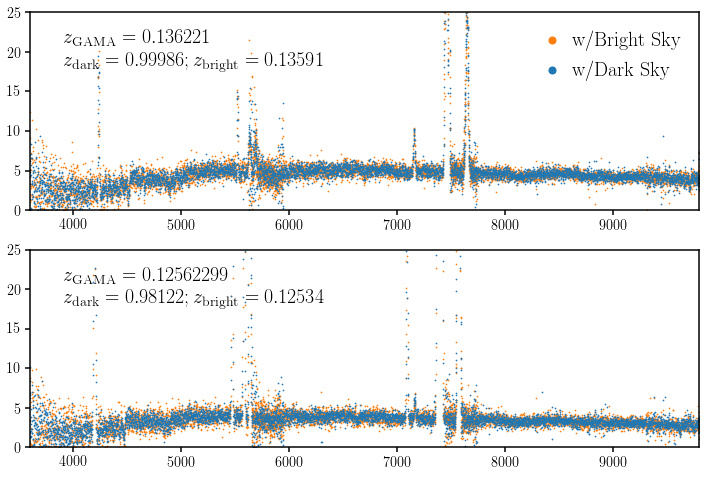

In [29]:
fig = plt.figure(figsize=(12,8))
for ii, i in enumerate(i_weird[:2]): 
    sub = fig.add_subplot(2,1,ii+1)
    for band in ['b', 'r', 'z']:
        sub.scatter(spec_bright.wave[band], spec_bright.flux[band][i].flatten(), c='C1', s=0.5, label='w/Bright Sky')
        sub.scatter(spec_dark.wave[band], spec_dark.flux[band][i].flatten(), c='C0', s=0.5, label='w/Dark Sky')
        if (ii == 0) and (band == 'b'): sub.legend(loc='upper right', markerscale=10, handletextpad=0., prop={'size': 20})
    print('Gama-Legacy index = %i' % i_dark[i])
    sub.set_xlim([3600., 9800.])
    sub.set_ylim([0., 25.])
    sub.text(0.05, 0.9, 
             r'$z_\mathrm{GAMA}='+str(redshift[i_dark[i]])+'$ \n $z_\mathrm{dark}='+str(round(zdark_data['Z'][i],5))+'; z_\mathrm{bright} = '+str(round(zbright_data['Z'][i],5))+'$', 
             ha='left', va='top', fontsize=20, transform=sub.transAxes)

Everythign looks as expected with the spectra... Now lets read in the redrock output of these spectra and take a look at them in detail

In [38]:
from redrock.external import desi
from redrock import templates as rr_templates

In [39]:
templates_path = rr_templates.find_templates(None)
templates = {} 
for el in templates_path: 
    t = rr_templates.Template(filename=el)
    templates[t.full_type] = t 

DEBUG: Using default redshift range 0.0050-1.6988 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-3.9968 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Carbon.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Ldwarf.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [40]:
def plotspec(target, zscan, zfit, xrange0=None, yrange0=None, xrange1=None, yrange1=None): 
    zfit_i = zfit[zfit['targetid'] == target[0].id]
    zz = zfit[zfit['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    fig = plt.figure(figsize=(12,8)) 
    _ax1 = fig.add_subplot(211)
    for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
        if spectype in zscan[target[0].id]:
            zx = zscan[target[0].id][spectype]
            _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                      label='_none_')
            _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                      label=spectype)
    _ax1.plot(zfit['z'], zfit['chi2'], 'r.', label='_none_')
    if xrange0 is not None: _ax1.set_xlim(xrange0)
    if yrange0 is not None: _ax1.set_ylim(yrange0)
    for row in zfit_i: 
        if xrange0 is not None or yrange0 is not None:
            if xrange0 is not None: xif = (row['z'] > xrange0[0]) & (row['z'] < xrange0[1])
            else: xif = True
            if yrange0 is not None: yif = (row['chi2'] > yrange0[0]) & (row['chi2'] < yrange0[1])
            else: yif = True
            if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
        else:
            _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
    _ax1.axvline(zz['z'], color='k', alpha=0.1)
    _ax1.axhline(zz['chi2'], color='k', alpha=0.1)
    _ax1.legend()
    _ax1.set_title('target {}  zbest={:.3f} {}'.format(target[0].id, zz['z'], zz['spectype']))
    _ax1.set_ylabel(r'$\chi^2$', fontsize=25)
    _ax1.set_xlabel('redshift', fontsize=25)
    
    _ax2 = fig.add_subplot(212)        
    specs_to_read = target[0].spectra
    ymin = ymax = 0.0
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        isbad = (spec.ivar == 0)
        ## model[isbad] = mx[isbad]
        flux[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(flux, 1), alpha=0.5)
        _ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), 'k-', alpha=0.8)

        ymin = min(ymin, np.percentile(flux[~isbad], 1))
        ymax = max(ymax, np.percentile(flux[~isbad], 99), np.max(model)*1.05)

    #- Label object type and redshift
    label = 'znum {} {} z={:.3f}'.format(0, tp.full_type, zz['z'])
    #print('target {} id {} {}'.format(self.itarget, target.id, label))
    ytext = ymin+0.9*(ymax-ymin)
    if xrange1 is not None: _ax2.text(xrange1[0], ytext, label)
    else: _ax2.text(3800, ytext, label)
    _ax2.set_ylim(ymin, ymax)
    _ax2.set_xlim(3500,10100)   
    _ax2.set_ylabel('flux', fontsize=25)
    _ax2.set_xlabel('wavelength [A]', fontsize=25)    
    fig.subplots_adjust(hspace=0.3)
    plt.show()

In [41]:
def chi2z(target, zscan, zfit, xranges=None, yranges=None):
    zfit_i = zfit[zfit['targetid'] == target[0].id]
    zz = zfit[zfit['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    fig = plt.figure(figsize=(4*len(xranges),4)) 
    for i in range(len(xranges)): 
        _ax1 = fig.add_subplot(1,len(xranges),i+1)
        for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
            if spectype in zscan[target[0].id]:
                zx = zscan[target[0].id][spectype]
                _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                          label='_none_')
                _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                          label=spectype)
        _ax1.plot(zfit['z'], zfit['chi2'], 'r.', label='_none_')
        if xranges is not None: _ax1.set_xlim(xranges[i])
        if yranges is not None: _ax1.set_ylim(yranges[i])
        for row in zfit_i: 
            if xranges is not None or yranges is not None:
                if xranges is not None: xif = (row['z'] > xranges[i][0]) & (row['z'] < xranges[i][1])
                else: xif = True
                if yranges is not None: yif = (row['chi2'] > yranges[i][0]) & (row['chi2'] < yranges[i][1])
                else: yif = True
                if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
            else:
                _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
        _ax1.axvline(zz['z'], color='k', alpha=0.1)
        _ax1.axhline(zz['chi2'], color='k', alpha=0.1)
        #_ax1.legend()
        _ax1.set_title('target {}  zbest={:.3f} {}'.format(target[0].id, zz['z'], zz['spectype']))
        _ax1.set_xlabel('redshift', fontsize=25)
        if i == 0: _ax1.set_ylabel(r'$\chi^2$', fontsize=25)
    fig.subplots_adjust(wspace=0.3)
    plt.show()

In [43]:
target_bright = desi.DistTargetsDESI(f_spec_bright)._my_data
target_dark = desi.DistTargetsDESI(f_spec_dark)._my_data

zscan_bright, zfit_bright = RedRock.results.read_zscan(f_out_bright)
zscan_dark, zfit_dark = RedRock.results.read_zscan(f_out_dark)

plotspec(target_bright, zscan_bright, zfit_bright, xrange0=[0.,1.1])
plotspec(target_dark, zscan_dark, zfit_dark, xrange0=[0.,1.1])

print('Simulated Spectra w/ Bright Sky')
chi2z(target_bright, zscan_bright, zfit_bright, xranges=[[0.16,0.18], [1.05, 1.08]])
print('Simulated Spectra w/ Dark Sky')
chi2z(target_dark, zscan_dark, zfit_dark, xranges=[[0.16,0.18], [1.05, 1.08]])

AssertionError: 

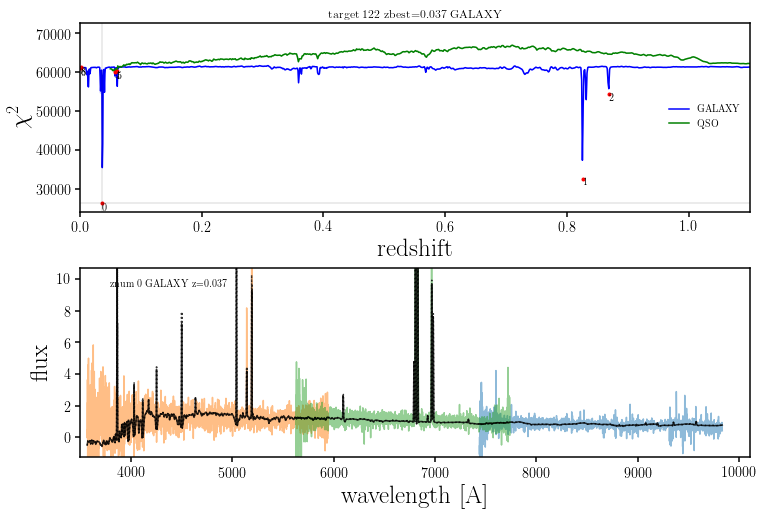

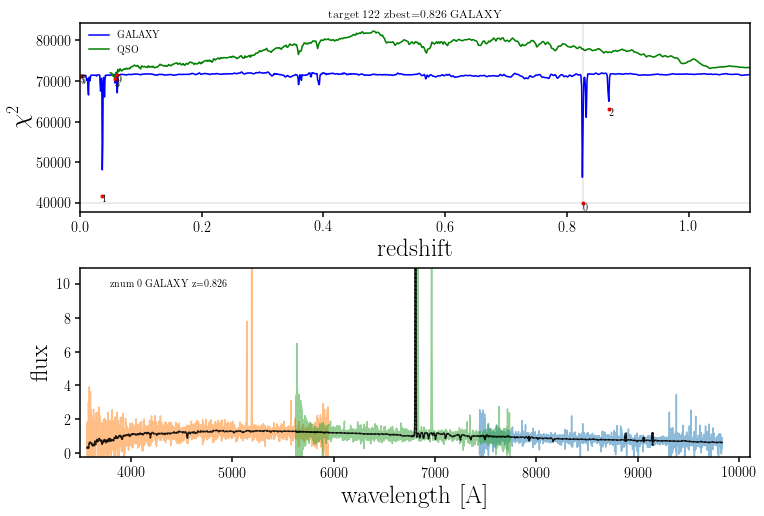

Simulated Spectra w/ Bright Sky


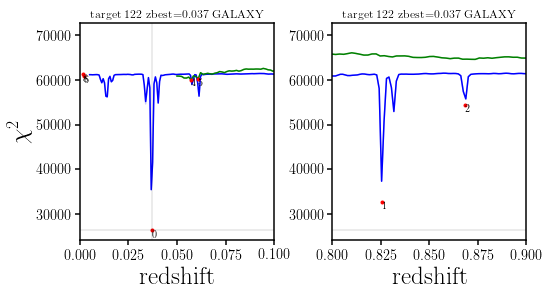

Simulated Spectra w/ Dark Sky


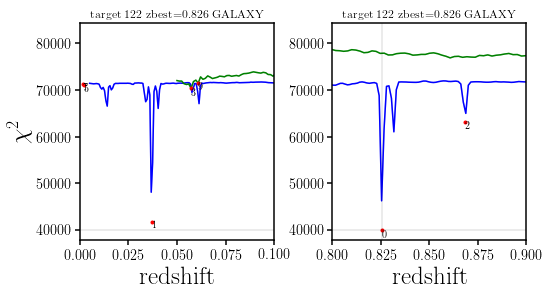

In [94]:
i = i_weird[1]
f_spec_bright = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 'weird_obj', str(i_dark[i]), '.brightsky.fits'])
f_spec_dark = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 'weird_obj', str(i_dark[i]), '.darksky.fits'])

# run redrock on it
f_red_bright = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/',
                        'weird_obj', str(i_dark[i]), '.brightsky.redrock.fits'])
f_red_dark = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 
                      'weird_obj', str(i_dark[i]), '.darksky.redrock.fits'])
f_out_bright = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 
                        'weird_obj', str(i_dark[i]), '.brightsky.redrock.h5'])
f_out_dark = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 
                      'weird_obj', str(i_dark[i]), '.darksky.redrock.h5'])
target_bright = desi.DistTargetsDESI(f_spec_bright)._my_data
target_dark = desi.DistTargetsDESI(f_spec_dark)._my_data

zscan_bright, zfit_bright = RedRock.results.read_zscan(f_out_bright)
zscan_dark, zfit_dark = RedRock.results.read_zscan(f_out_dark)

plotspec(target_bright, zscan_bright, zfit_bright, xrange0=[0.,1.1])
plotspec(target_dark, zscan_dark, zfit_dark, xrange0=[0.,1.1])
print('Simulated Spectra w/ Bright Sky')
chi2z(target_bright, zscan_bright, zfit_bright, xranges=[[0.,0.1], [0.8, 0.9]])
print('Simulated Spectra w/ Dark Sky')
chi2z(target_dark, zscan_dark, zfit_dark, xranges=[[0.,0.1], [0.8, 0.9]])

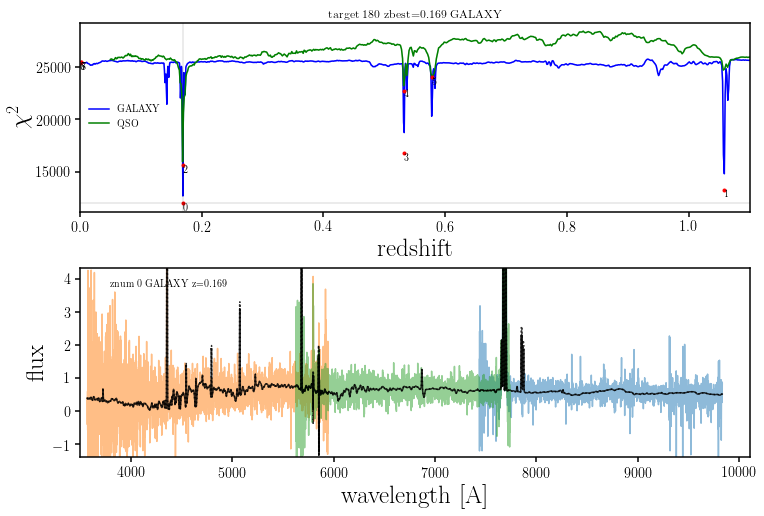

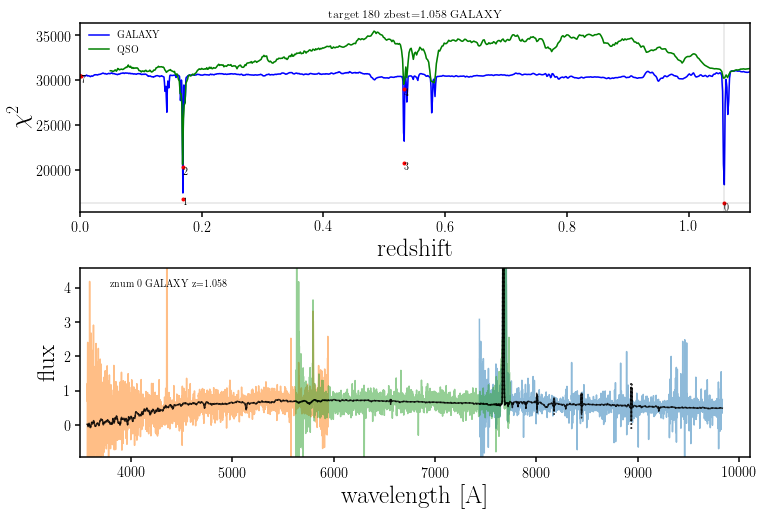

Simulated Spectra w/ Bright Sky


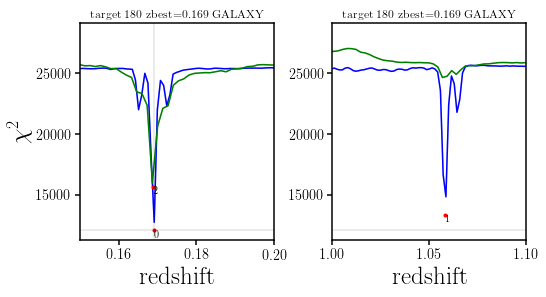

Simulated Spectra w/ Dark Sky


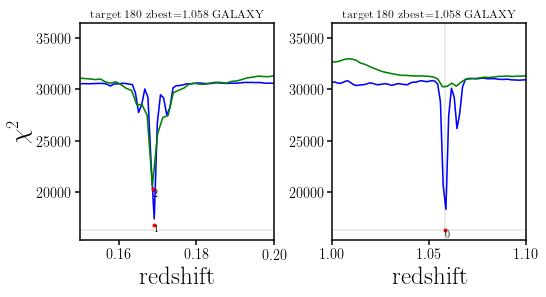

In [97]:
i = i_weird[2]
f_spec_bright = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 'weird_obj', str(i_dark[i]), '.brightsky.fits'])
f_spec_dark = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 'weird_obj', str(i_dark[i]), '.darksky.fits'])

# run redrock on it
f_red_bright = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/',
                        'weird_obj', str(i_dark[i]), '.brightsky.redrock.fits'])
f_red_dark = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 
                      'weird_obj', str(i_dark[i]), '.darksky.redrock.fits'])
f_out_bright = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 
                        'weird_obj', str(i_dark[i]), '.brightsky.redrock.h5'])
f_out_dark = ''.join([UT.dat_dir(), 'redrock_outlier_spectra/', 
                      'weird_obj', str(i_dark[i]), '.darksky.redrock.h5'])
target_bright = desi.DistTargetsDESI(f_spec_bright)._my_data
target_dark = desi.DistTargetsDESI(f_spec_dark)._my_data

zscan_bright, zfit_bright = RedRock.results.read_zscan(f_out_bright)
zscan_dark, zfit_dark = RedRock.results.read_zscan(f_out_dark)

plotspec(target_bright, zscan_bright, zfit_bright, xrange0=[0.,1.1])
plotspec(target_dark, zscan_dark, zfit_dark, xrange0=[0.,1.1])
print('Simulated Spectra w/ Bright Sky')
chi2z(target_bright, zscan_bright, zfit_bright, xranges=[[0.15,0.2], [1.,1.1]])
print('Simulated Spectra w/ Dark Sky')
chi2z(target_dark, zscan_dark, zfit_dark, xranges=[[0.15,0.2], [1.,1.1]])